## 作業
在鐵達尼資料集中，   
可以用今天範例中提到的三種辨識異常值的方法，  
以 training data 為資料集。  
1.觀察票價是否有異常值的現象?  
2.你覺得找出的異常是真的異常? 你覺得需要做處理嗎?  
(試著講出自己的想法。)  


### 資料
鐵達尼號 train 資料集


In [1]:
# library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn  as sns
from scipy import stats
import math
import statistics
#讓圖可以在 jupyter notebook顯示
%matplotlib inline

In [2]:
df_train = pd.read_csv("Titanic_train.csv")
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### 探索性分析:
*  觀察-是否有異常值  
我們來觀察一下 Fare 變數吧!!

## Q1:觀察票價是否有異常值的現象?

## 方法1
* 進行一個描述性的統計（規定範圍），從而檢視哪些值是不合理的（範圍以外的值）。  


In [3]:
df_train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


(array([732., 106.,  31.,   2.,  11.,   6.,   0.,   0.,   0.,   3.]),
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <a list of 10 Patch objects>)

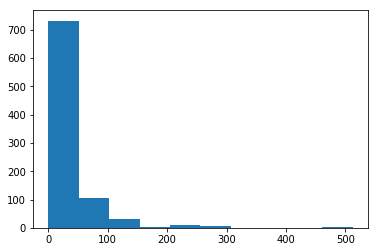

In [52]:
plt.hist(df_train['Fare'])

## 方法 2
* 進行3倍標準差原則的計算，從而檢視哪些值是可疑的異常值。  


In [34]:
def outliers_z_score(ys,times):
    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys] 
    return np.where(np.array(z_scores) > times)

out_index=outliers_z_score(df_train['Fare'],3)
print(out_index[0])
print("用第二種方法的找出的 outlier 有哪些?")
print(df_train.loc[out_index[0],'Fare'])

[ 27  88 118 258 299 311 341 377 380 438 527 557 679 689 700 716 730 737
 742 779]
用第二種方法的找出的 outlier 有哪些?
27     263.0000
88     263.0000
118    247.5208
258    512.3292
299    247.5208
311    262.3750
341    263.0000
377    211.5000
380    227.5250
438    263.0000
527    221.7792
557    227.5250
679    512.3292
689    211.3375
700    227.5250
716    227.5250
730    211.3375
737    512.3292
742    262.3750
779    211.3375
Name: Fare, dtype: float64


## 方法3-盒鬚圖判別法(IQR method)

In [50]:
def outliers_iqr(ys,times):
    #注意 使用 np.percentile 要去除 nan 要不然計算出來會錯誤，所以我們採用下者的程式 np.nanpercentile
    #quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    quartile_1, quartile_3 = np.nanpercentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * times)
    upper_bound = quartile_3 + (iqr * times)
    return np.where((ys > upper_bound) | (ys < lower_bound))

out_index2=outliers_iqr(df_train['Fare'],3)
print(out_index2)
print("用第三種方法的找出的 outlier 有哪些?(1.5 倍IQR)")
print(df_train.loc[out_index2[0],'Fare'])

(array([ 27,  31,  88, 118, 195, 215, 258, 268, 269, 297, 299, 305, 306,
       307, 311, 318, 319, 325, 332, 334, 337, 341, 373, 377, 380, 390,
       393, 435, 438, 498, 505, 527, 537, 544, 550, 557, 581, 609, 659,
       660, 679, 689, 698, 700, 708, 716, 730, 737, 742, 763, 779, 802,
       856], dtype=int64),)
用第三種方法的找出的 outlier 有哪些?(1.5 倍IQR)
27     263.0000
31     146.5208
88     263.0000
118    247.5208
195    146.5208
215    113.2750
258    512.3292
268    153.4625
269    135.6333
297    151.5500
299    247.5208
305    151.5500
306    110.8833
307    108.9000
311    262.3750
318    164.8667
319    134.5000
325    135.6333
332    153.4625
334    133.6500
337    134.5000
341    263.0000
373    135.6333
377    211.5000
380    227.5250
390    120.0000
393    113.2750
435    120.0000
438    263.0000
498    151.5500
505    108.9000
527    221.7792
537    106.4250
544    106.4250
550    110.8833
557    227.5250
581    110.8833
609    153.4625
659    113.2750
660    133.6500
679    51

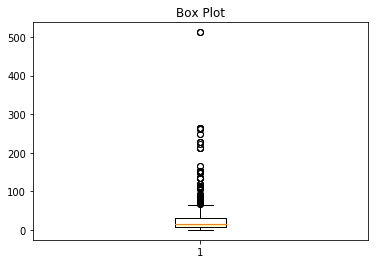

In [54]:
plt.boxplot(df_train['Fare'],whis=1.5) 
plt.title('Box Plot')
plt.show()

## Q2:你覺得找出的異常是真的異常? 你覺得需要做處理嗎?


In [53]:
'''未必是異常,很高的票價可能是VIP的船票價,但為了機器良好的學習,還是要做處理'''

'未必是異常,很高的票價可能是VIP的船票價,但為了機器良好的學習,還是要做處理'